<a href="https://colab.research.google.com/github/VitalyGladyshev/med_work/blob/main/PolypsSegmentationGlVV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Сегментация полипов

## Гладышев В.В.

## Импорты

In [3]:
import os
import cv2
from PIL import Image
from matplotlib import pyplot as plt
import numpy as np

from tensorflow import keras
from keras.optimizers import Adam
from keras.utils import normalize , img_to_array
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization
from keras.layers import Activation, Concatenate , UpSampling2D
import tensorflow as tf
from tensorflow.keras import backend as K

from sklearn.model_selection import train_test_split

## Подготовка данных

In [2]:
!unzip -q /content/archive.zip

Загрузка изображений

In [4]:
def load_images_from_folder(folder , check = False):
    images = []

    for filename in sorted(os.listdir(folder)):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path)

        if check :
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        img = cv2.resize(img, (128, 128))
        img_array = np.array(img)
        images.append(img_array)

    return np.array(images)

Подготовка масок

In [5]:
def preprocess_mask(mask, blur=False):
    # Уменьшение размытости
    if blur:
        mask = cv2.GaussianBlur(mask, (3, 3), 0)

    # Нормализация в диапазон [0, 1]
    mask_normalized = mask // 255.0

    mask_final = np.expand_dims(mask_normalized, axis=-1)

    return mask_final

Подготовка изображений

In [6]:
def preprocess_images(images, denoise=False, blur=False):
    processed_images = []

    for image in images:

        img_processed = image.copy()

        # Подавление шума
        if denoise:
            img_processed = cv2.fastNlMeansDenoisingColored(img_processed, None, 10, 10, 7, 21)

        # Уменьшение размытости
        if blur:
            img_processed = cv2.GaussianBlur(img_processed, (3, 3), 1.5)

        # Нормализация в диапазон [0, 1]
        img_processed = img_processed / 255.0

        processed_images.append(img_processed)

    return np.array(processed_images)

Загрузка фотографий из папок "изображения" и "маски"

In [7]:
path_folder_images = '/content/Kvasir-Capsule/images'
paht_folder_masks = '/content/Kvasir-Capsule/masks'

x = load_images_from_folder(path_folder_images)
y = load_images_from_folder(paht_folder_masks , True)

x = preprocess_images(x , denoise = True , blur = False)
y = preprocess_mask(y , blur = False)

print(x.shape)
print(y.shape)

(55, 128, 128, 3)
(55, 128, 128, 1)


### Разделение на тренировочный и валидационный+тестовый наборы

In [8]:
x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=0.45, random_state=42)

# Разделение на валидационный и тестовый наборы
x_valid, x_test, y_valid, y_test = train_test_split(x_temp, y_temp, test_size=0.6, random_state=42)

print("Train data shapes:", x_train.shape, y_train.shape)
print("Validation data shapes:", x_valid.shape, y_valid.shape)
print("Test data shapes:", x_test.shape, y_test.shape)

Train data shapes: (30, 128, 128, 3) (30, 128, 128, 1)
Validation data shapes: (10, 128, 128, 3) (10, 128, 128, 1)
Test data shapes: (15, 128, 128, 3) (15, 128, 128, 1)


## Построение модели

In [9]:
def Convolution(input, num_filters, bl_name):
  x = Conv2D(num_filters, 3, padding='same',name = 'Conv1_' + bl_name)(input)
  x = BatchNormalization(name='Norm1_'+bl_name)(x)
  x = Activation('relu', name='Act1_'+bl_name)(x)

  x = Conv2D(num_filters, 3,padding='same',name='Conv2_'+bl_name)(x)
  x = BatchNormalization(name='Norm2_'+bl_name)(x)
  x = Activation('relu', name='Act2_'+bl_name)(x)

  return x


def Encoder(input, num_filters, block_name):
  s = Convolution(input, num_filters, block_name)
  p = MaxPooling2D((2,2),name='MaxPooling_'+block_name)(s)

  return s, p


def Decoder(input, x_up , num_filters, block_name):
  input.append(UpSampling2D()(x_up))

  concat = concatenate(input)
  d = Convolution(concat , num_filters , bl_name = block_name)

  return d

In [10]:
def Unet_plus_plus(input_shape=(256, 256, 3), num_classes=1, base_filter=32, deep_supervision=False) :
  inputs = Input(shape=input_shape)

  bf = base_filter
  filters = [bf, bf*2, bf*4, bf*8, bf*16]

  # Encoding Path
  x_00 , Pooling_00 = Encoder(inputs, filters[0], 'Encoder_00')
  x_10 , Pooling_10 = Encoder(Pooling_00, filters[1], 'Encoder01')
  x_20 , Pooling_20 = Encoder(Pooling_10, filters[2], 'Encoder02')
  x_30 , Pooling_30 = Encoder(Pooling_20, filters[3], 'Encoder03')
  x_40 , Pooling_40 = Encoder(Pooling_30, filters[4], 'Encoder04')

  # Nested Decoding Path
  x_01 = Decoder(input = [x_00] , x_up = x_10 , num_filters = filters[0], block_name = 'Decoder01')
  x_11 = Decoder(input = [x_10] , x_up = x_20 , num_filters = filters[1], block_name = 'Decoder11')
  x_21 = Decoder(input = [x_20] , x_up = x_30 , num_filters = filters[2], block_name = 'Decoder21')
  x_31 = Decoder(input = [x_30] , x_up = x_40 , num_filters = filters[3], block_name = 'Decoder31')


  x_02 = Decoder(input = [x_00 , x_01] , x_up = x_11 , num_filters = filters[0],  block_name = 'Decoder02')
  x_12 = Decoder(input = [x_10 , x_11] , x_up = x_21 , num_filters = filters[1],  block_name = 'Decoder12')
  x_22 = Decoder(input = [x_20 , x_21] , x_up = x_31 , num_filters = filters[2],  block_name = 'Decoder22')


  x_03 = Decoder(input = [x_00 , x_01 , x_02] , x_up = x_12 , num_filters = filters[0],  block_name = 'Decoder03')
  x_13 = Decoder(input = [x_10 , x_11 , x_12] , x_up = x_22 , num_filters = filters[1],  block_name = 'Decoder13')

  x_04 = Decoder(input = [x_00 , x_01 , x_02 , x_03] , x_up = x_13 , num_filters = filters[0],  block_name = 'Decoder04')


  # Deep Supervision Path
  if deep_supervision:
    outputs = [
      Conv2D(num_classes, 1, activation='sigmoid', name='output_L1')(x_01),
      Conv2D(num_classes, 1, activation='sigmoid', name='output_L2')(x_02),
      Conv2D(num_classes, 1, activation='sigmoid', name='output_L3')(x_03),
      Conv2D(num_classes, 1, activation='sigmoid', name='output_L4')(x_04)
  ]
    outputs = keras.layers.average(outputs)

  else:
    outputs = Conv2D(num_classes, 1, activation='sigmoid', name='output')(x_04)

  model = Model(inputs=inputs, outputs=outputs, name='Unet_plus_plus')

  return model

Создание модели

In [17]:
input_shapes = (128,128,3)
unet_model = Unet_plus_plus(input_shape = input_shapes, num_classes = 1 , base_filter=32, deep_supervision=True)
unet_model.summary()

Model: "Unet_plus_plus"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_Encoder_00 (Conv2D) │ (None, 128, 128, 32)   │            896 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Norm1_Encoder_00          │ (None, 128, 128, 32)   │            128 │ Conv1_Encoder_00[0][0] │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Act1_Encoder_00           │ (None, 128, 128, 32)   │              0 │ Norm1_Encoder_00[0][0] │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv2_Encoder_00 (Conv2D) │ (None, 128, 128, 32)   │          9,248 │ Act1_Encoder_00[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Norm2_Encoder_00          │ (None, 128, 128, 32)   │            128 │ Conv2_Encoder_00[0][0] │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Act2_Encoder_00           │ (None, 128, 128, 32)   │              0 │ Norm2_Encoder_00[0][0] │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ MaxPooling_Encoder_00     │ (None, 64, 64, 32)     │              0 │ Act2_Encoder_00[0][0]  │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_Encoder01 (Conv2D)  │ (None, 64, 64, 64)     │         18,496 │ MaxPooling_Encoder_00… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Norm1_Encoder01           │ (None, 64, 64, 64)     │            256 │ Conv1_Encoder01[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Act1_Encoder01            │ (None, 64, 64, 64)     │              0 │ Norm1_Encoder01[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv2_Encoder01 (Conv2D)  │ (None, 64, 64, 64)     │         36,928 │ Act1_Encoder01[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Norm2_Encoder01           │ (None, 64, 64, 64)     │            256 │ Conv2_Encoder01[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Act2_Encoder01            │ (None, 64, 64, 64)     │              0 │ Norm2_Encoder01[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ MaxPooling_Encoder01 

 Total params: 9,170,724 (34.98 MB)

 Trainable params: 9,163,428 (34.96 MB)

 Non-trainable params: 7,296 (28.50 KB)

### Компиляция модели

In [18]:
def dice_coef2(y_true, y_pred, smooth=0.01):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return dice

def bce_dice_loss(target, prediction):
    return 0.5 * binary_crossentropy(target, prediction) - dice_coef2(target, prediction)

In [19]:
adam_optimizer = Adam(learning_rate=3e-4)

# Компиляция модели
unet_model.compile(loss=bce_dice_loss,
                   optimizer=adam_optimizer,  # Оптимизатор Adam со скоростью обучения 3e-4
                   metrics=['accuracy'])

# Сохраняем лучший набор
checkpoint_filepath = os.path.join(os.getcwd(), 'checkpoint.weights.h5')
mcp = keras.callbacks.ModelCheckpoint(
    checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    save_best_only=True
)
es = keras.callbacks.EarlyStopping(
    patience = 10,
    monitor = 'val_loss',
    start_from_epoch = 150
)

### Обучение модели

In [20]:
batch_size = 8
epochs = 200
train_ds = tf.data.Dataset.from_tensor_slices((x_train,y_train)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
valid_ds = tf.data.Dataset.from_tensor_slices((x_valid,y_valid)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

history = unet_model.fit(train_ds,
                         validation_data=valid_ds,
                         epochs=epochs,
                         callbacks = [mcp,es],
                         verbose = 1, shuffle=True)

Epoch 1/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 49s 6s/step - accuracy: 0.7865 - loss: -0.3832 - val_accuracy: 0.5947 - val_loss: -0.2044
Epoch 2/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.9262 - loss: -0.6838 - val_accuracy: 0.5947 - val_loss: -0.2298
Epoch 3/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 324ms/step - accuracy: 0.9322 - loss: -0.7599 - val_accuracy: 0.5947 - val_loss: -0.2551
Epoch 4/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 323ms/step - accuracy: 0.9351 - loss: -0.7938 - val_accuracy: 0.5947 - val_loss: -0.2753
Epoch 5/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 313ms/step - accuracy: 0.9389 - loss: -0.8124 - val_accuracy: 0.5947 - val_loss: -0.2909
Epoch 6/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 317ms/step - accuracy: 0.9439 - loss: -0.8257 - val_accuracy: 0.5947 - val_loss: -0.3018
Epoch 7/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 306ms/step - accuracy: 0.9486 - loss: -0.8359 - val_accuracy: 0.5947 - val_loss: -0.3096
Epoch 8/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 316ms/step - accuracy: 0.9525 - loss: -0.8454 - val_accuracy: 

## Графики Loss и Accuracy

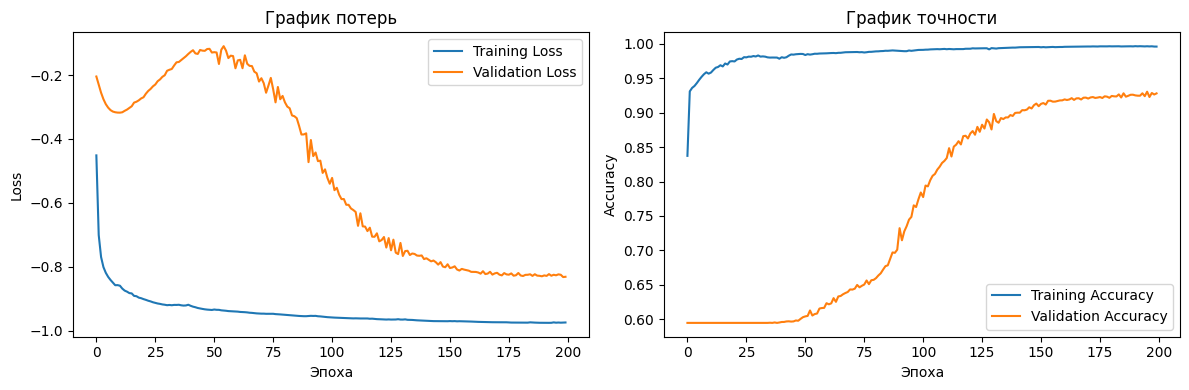

In [21]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('График потерь')
plt.xlabel('Эпоха')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('График точности')
plt.xlabel('Эпоха')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## Оценка модели

In [22]:
unet_model.load_weights(checkpoint_filepath)
evaluation = unet_model.evaluate(x=x_test, y=y_test)

print("Test Loss:", evaluation[0])
print("Test Accuracy:", evaluation[1])

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - accuracy: 0.9311 - loss: -0.8242
Test Loss: -0.8241555690765381
Test Accuracy: 0.9311279058456421


Разделение по threshold на 0 и 1

In [23]:
def binarize_predictions(predictions, threshold=0.5):
  binary_predictions = (predictions >= threshold).astype('float64')
  return binary_predictions

In [24]:
predictions = unet_model.predict(x_test)

predictions = binarize_predictions(predictions , threshold = 0.5)

predictions.shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


(15, 128, 128, 1)

## Визуализация результата

In [25]:
def dice_coef(target, prediction, axis=(1, 2), smooth=0.01):

  prediction = K.round(prediction)  # Round to 0 or 1

  intersection = tf.reduce_sum(target * prediction, axis=axis)
  union = tf.reduce_sum(target + prediction, axis=axis)
  numerator = tf.constant(2.0, dtype=target.dtype) * intersection + smooth
  denominator = union + smooth
  coef = numerator / denominator

  return tf.reduce_mean(coef)

In [29]:
def Show_images_CT_Mask_Pred(X_test, Y_test, Predictions, qual=5):
  for i in range(qual):
    plt.figure(figsize=(15, 5))

    # Изображение
    plt.subplot(1, 3, 1)
    plt.imshow(X_test[i, ..., 0] , cmap = 'gray')
    plt.title('Изображение')

    # Маска
    plt.subplot(1, 3, 2)
    plt.imshow(Y_test[i, ..., 0], cmap='gray')
    plt.title('Маска')

    # Сегментация
    plt.subplot(1, 3, 3)
    plt.imshow(Predictions[i, ..., 0], cmap='gray')
    plt.title('Сегментация')

    plt.show()

    # Коэффициент Dice
    dice_coef_value = dice_coef(Y_test[i], Predictions[i])
    print(f'Коэффициент Dice {i + 1}: {dice_coef_value}')

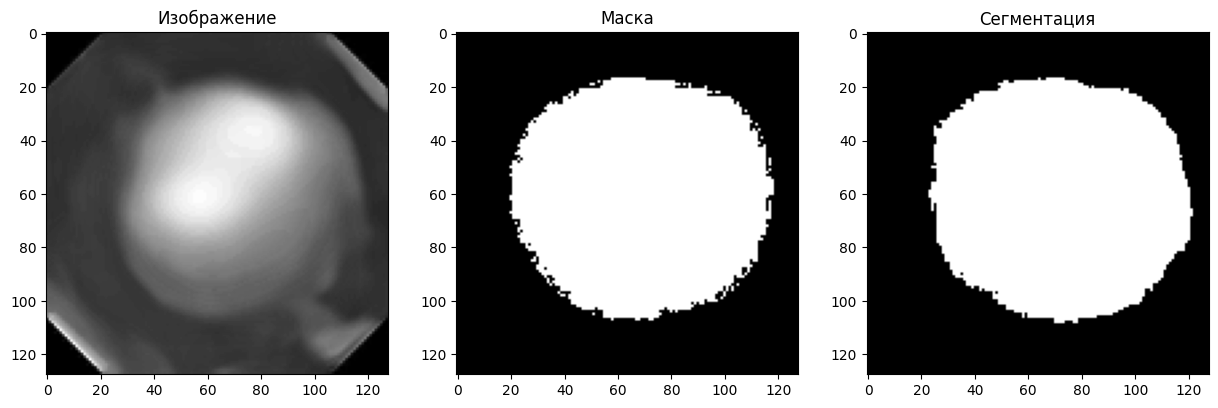

Коэффициент Dice 1: 0.9462329901797326


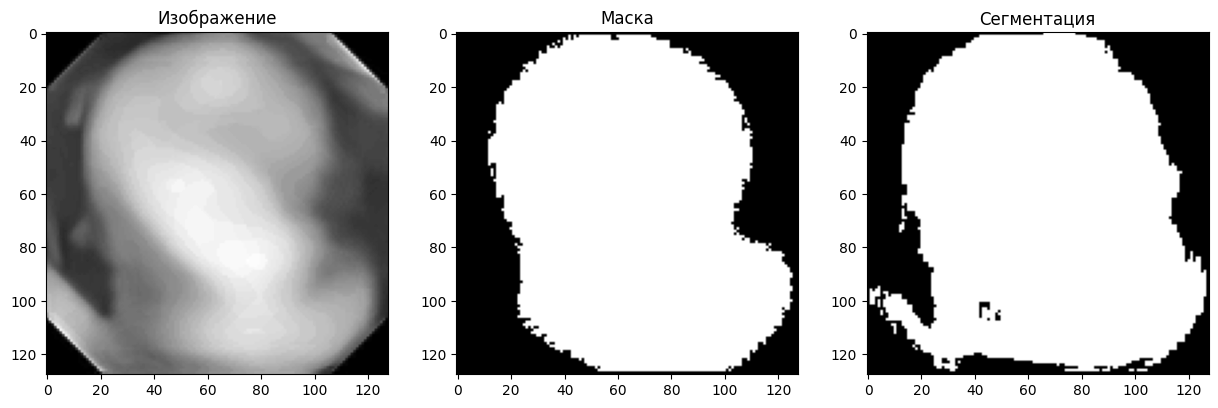

Коэффициент Dice 2: 0.9309783210560441


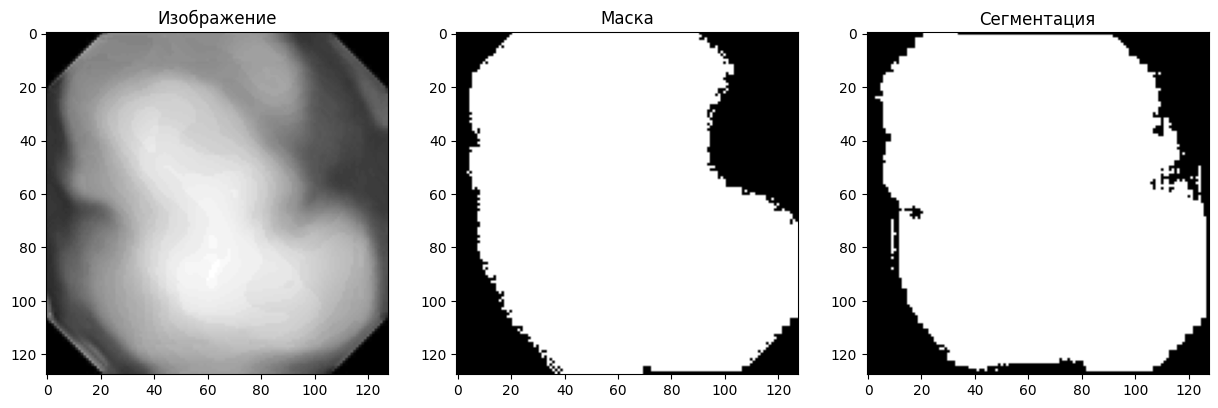

Коэффициент Dice 3: 0.9393123417992539


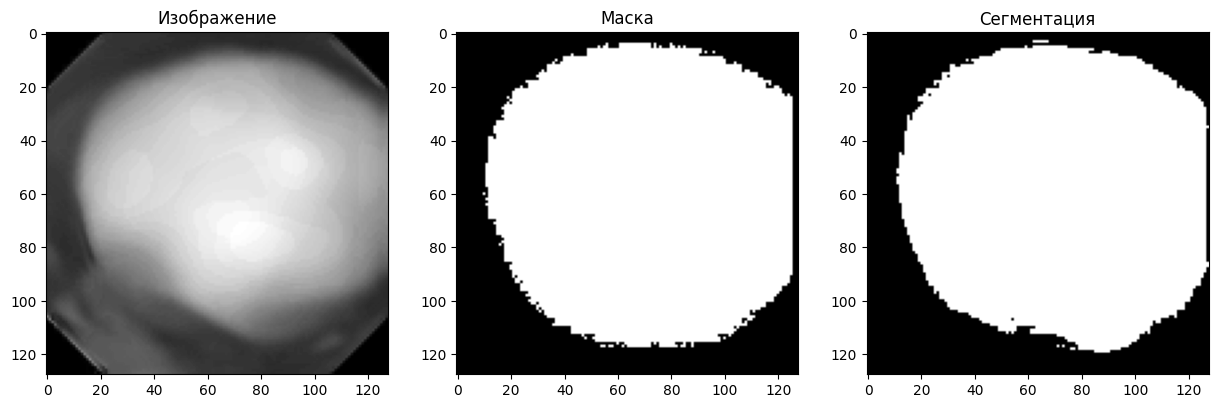

Коэффициент Dice 4: 0.9314776599503513


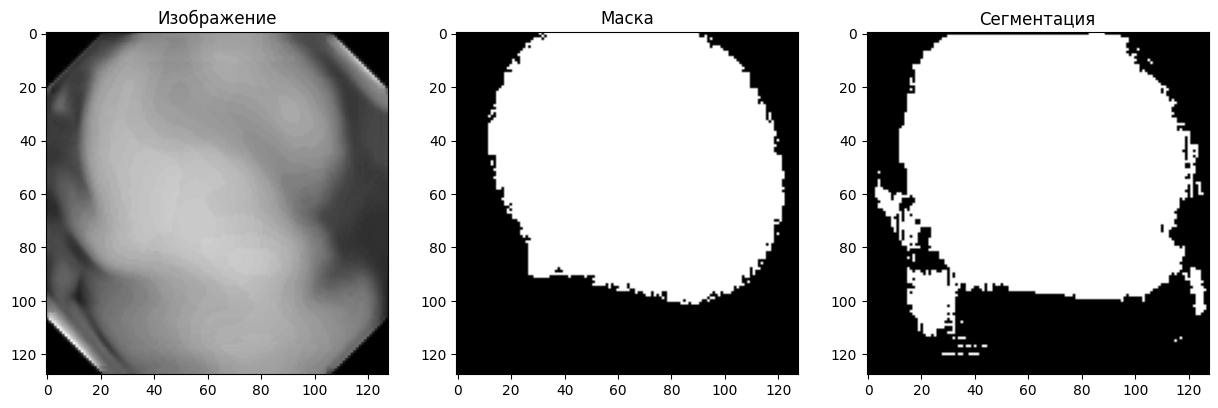

Коэффициент Dice 5: 0.8038235062124315


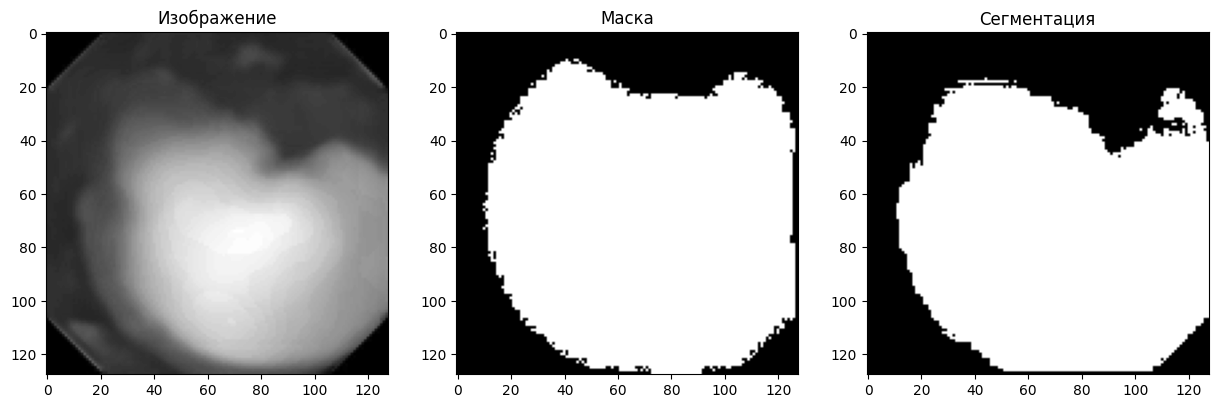

Коэффициент Dice 6: 0.8638314082652185


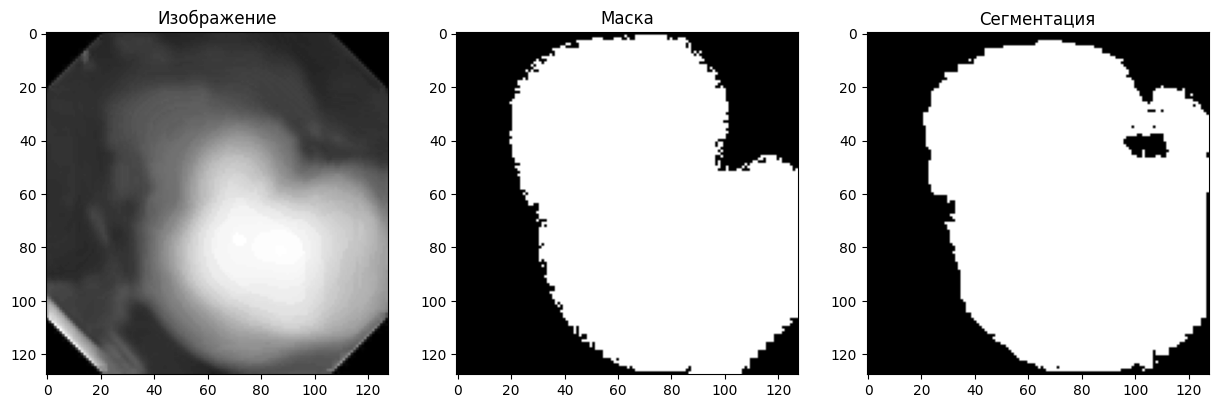

Коэффициент Dice 7: 0.920615624355607


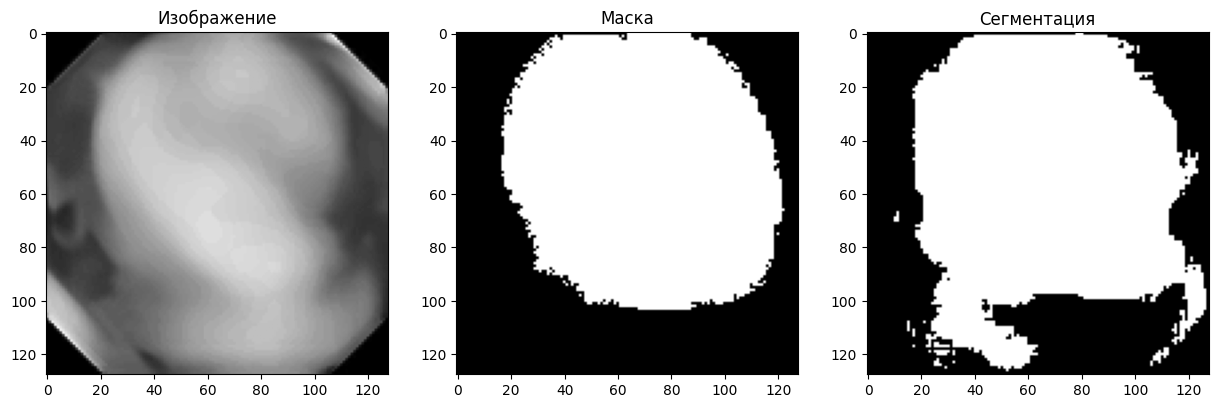

Коэффициент Dice 8: 0.7458720755512758


In [30]:
Show_images_CT_Mask_Pred(x_test , y_test , predictions , qual = 8)

## Сохранение лучшей модели

In [28]:
model_savepath = os.path.join(os.getcwd(), 'model.best.keras')
unet_model.save(model_savepath)

## Заключение

Использован датасет Kvasir-Capsule - набор изображений полученных камерой в виде пилюли при прохождениее через пищеварительный тракт

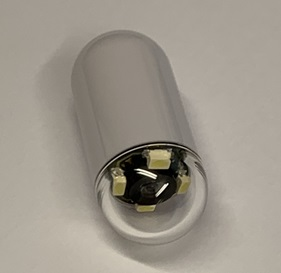

Набор изображений имеет маленький размера (55 изображений) и может быть ограниченно применим для машинного обучения в медицинских целях

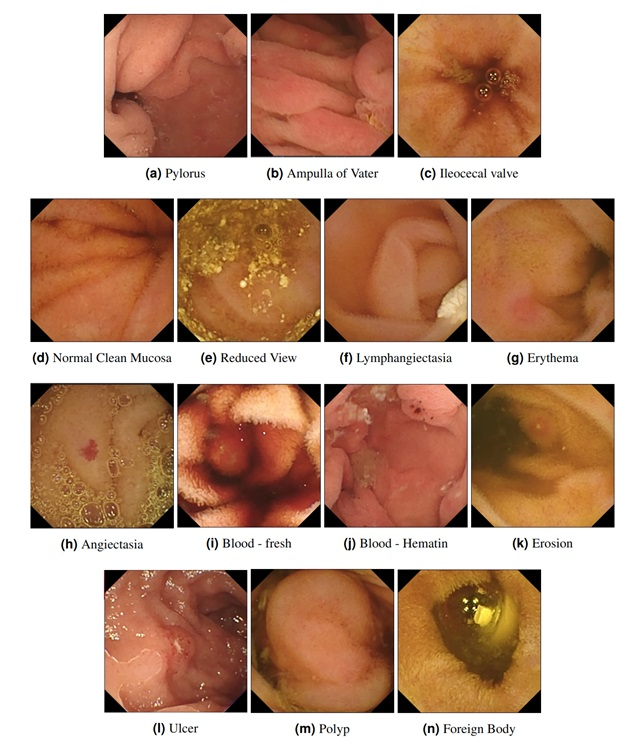

Каждое изображение сопровождается маской разметки<br>
Для целей сегментации медицинских изображений была использована нейронная сеть с архитектурой UNet++ (https://www.geeksforgeeks.org/unet-architecture-explained/?ref=ml_lbp)

Для расчёта потерь использовалась функция на базе коэффицента Dice. Применён оптимизатор Adam и метрика Accuracy. При обучении использовался батч размером 8. Цикл обучения составил 200 эпох. Сохранён лучший чекпоинт. На тестовом наборе получено значение accuracy: > 0.9311

Учитывая размер датасета полученная модель может только ограниченно быть использована в медицинских целях (для предварительной оценки)